In [1]:
!pip install torch torchvision timm tensorflow tensorflow-hub


  Using cached torchvision-0.22.1-cp310-cp310-win_amd64.whl (1.7 MB)
     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
     - -------------------------------------- 0.1/2.5 MB 2.6 MB/s eta 0:00:01
     ---- ----------------------------------- 0.3/2.5 MB 2.8 MB/s eta 0:00:01
     ------- -------------------------------- 0.5/2.5 MB 3.7 MB/s eta 0:00:01
     -------- ------------------------------- 0.5/2.5 MB 3.2 MB/s eta 0:00:01
     --------- ------------------------------ 0.6/2.5 MB 3.2 MB/s eta 0:00:01
     ----------- ---------------------------- 0.7/2.5 MB 2.9 MB/s eta 0:00:01
     --------------- ------------------------ 1.0/2.5 MB 3.2 MB/s eta 0:00:01
     ---------------- ----------------------- 1.0/2.5 MB 3.2 MB/s eta 0:00:01
     ------------------ --------------------- 1.2/2.5 MB 3.1 MB/s eta 0:00:01
     -------------------- ------------------- 1.3/2.5 MB 3.2 MB/s eta 0:00:01
     ---------------------- ----------------- 1.4/2.5 MB 3.2 MB/s eta 0:00:01
  


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import timm
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder("skin_split_keras/train", transform=transform)
val_dataset = datasets.ImageFolder("skin_split_keras/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Load MobileViT model
model = timm.create_model('mobilevit_s', pretrained=True, num_classes=2)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Training loop
for epoch in range(10):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} done.")

# Save
torch.save(model.state_dict(), "mobilevit_s.pth")


Epoch 1 done.
Epoch 2 done.
Epoch 3 done.
Epoch 4 done.
Epoch 5 done.
Epoch 6 done.
Epoch 7 done.
Epoch 8 done.
Epoch 9 done.
Epoch 10 done.


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt
import numpy as np

model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Default threshold = 0.5
preds = (all_probs >= 0.5).astype(int)

# Metrics
acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds)
rec = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)
auc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, preds)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1-score:", f1)
print("AUC:", auc)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(all_labels, preds))


Accuracy: 0.8848080133555927
Precision: 0.7169811320754716
Recall: 0.7228260869565217
F1-score: 0.7198917456021651
AUC: 0.9274272066206225
Confusion Matrix:
 [[1324  105]
 [ 102  266]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93      1429
           1       0.72      0.72      0.72       368

    accuracy                           0.88      1797
   macro avg       0.82      0.82      0.82      1797
weighted avg       0.89      0.88      0.88      1797



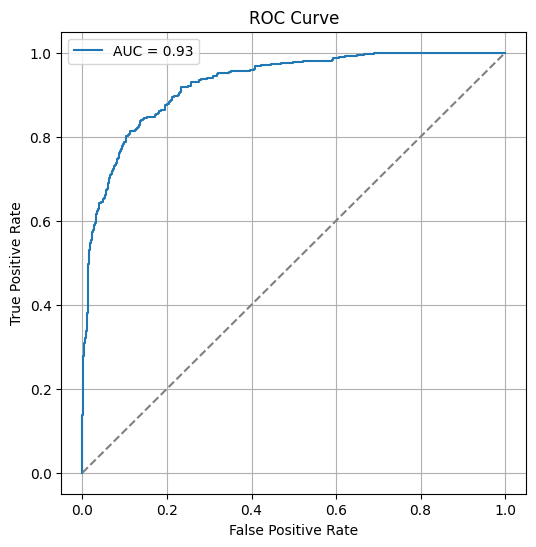

In [7]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


In [8]:
j_scores = tpr - fpr
best_thresh_index = np.argmax(j_scores)
best_threshold = thresholds[best_thresh_index]

print("Best Threshold (Youden's J):", best_threshold)

Best Threshold (Youden's J): 0.07035604


In [9]:
preds_best = (all_probs >= best_threshold).astype(int)
print("Classification Report (Best Threshold):\n", classification_report(all_labels, preds_best))


Classification Report (Best Threshold):
               precision    recall  f1-score   support

           0       0.95      0.86      0.91      1429
           1       0.61      0.84      0.71       368

    accuracy                           0.86      1797
   macro avg       0.78      0.85      0.81      1797
weighted avg       0.88      0.86      0.86      1797




[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


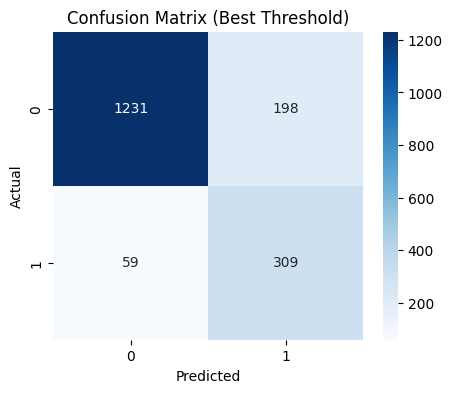

In [11]:
!pip install seaborn
import seaborn as sns
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(all_labels, preds_best), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Best Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


 Accuracy: 0.8993325917686318
 Precision: 0.7486772486772487
 Recall: 0.7669376693766937
 F1-score: 0.7576974564926372
 AUC: 0.9355150094538034

 Confusion Matrix:
 [[1334   95]
 [  86  283]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.94      1429
           1       0.75      0.77      0.76       369

    accuracy                           0.90      1798
   macro avg       0.84      0.85      0.85      1798
weighted avg       0.90      0.90      0.90      1798



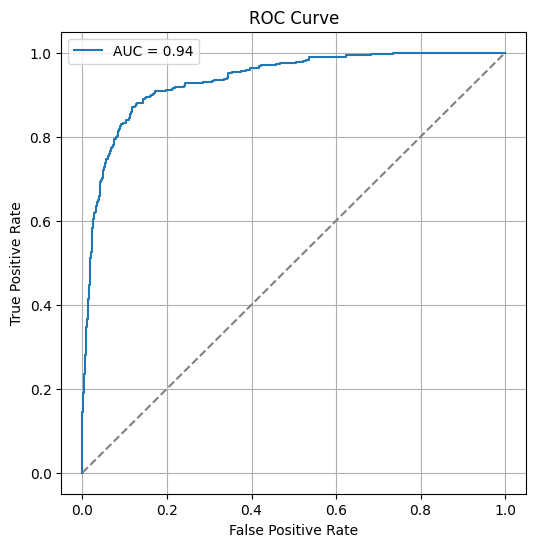

 Best Threshold (Youden's J): 0.0924

 Classification Report (Best Threshold):
               precision    recall  f1-score   support

           0       0.96      0.88      0.92      1429
           1       0.66      0.87      0.75       369

    accuracy                           0.88      1798
   macro avg       0.81      0.88      0.84      1798
weighted avg       0.90      0.88      0.89      1798



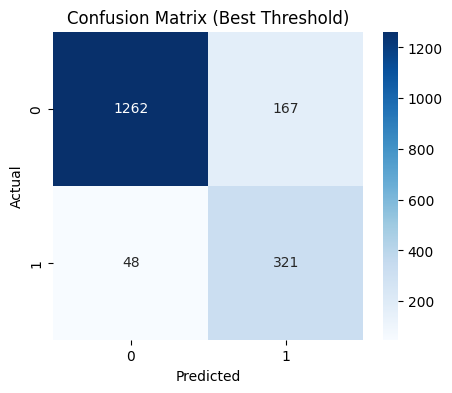

In [14]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ----------------------------
# Load Test Set
# ----------------------------
test_dataset = datasets.ImageFolder("skin_split_keras/test", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)

# ----------------------------
# Evaluate on Test Set
# ----------------------------
model.eval()
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Class 1 probabilities

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# ----------------------------
# Default threshold = 0.5
# ----------------------------
preds = (all_probs >= 0.5).astype(int)

# ----------------------------
# Metrics
# ----------------------------
acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds)
rec = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)
auc = roc_auc_score(all_labels, all_probs)
cm = confusion_matrix(all_labels, preds)

print(" Accuracy:", acc)
print(" Precision:", prec)
print(" Recall:", rec)
print(" F1-score:", f1)
print(" AUC:", auc)
print("\n Confusion Matrix:\n", cm)
print("\n Classification Report:\n", classification_report(all_labels, preds))

# ----------------------------
# ROC Curve
# ----------------------------
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

# ----------------------------
# Best Threshold (Youden’s J statistic)
# ----------------------------
j_scores = tpr - fpr
best_thresh_index = np.argmax(j_scores)
best_threshold = thresholds[best_thresh_index]
print(f" Best Threshold (Youden's J): {best_threshold:.4f}")

# ----------------------------
# Recalculate Metrics with Best Threshold
# ----------------------------
preds_best = (all_probs >= best_threshold).astype(int)
print("\n Classification Report (Best Threshold):\n", classification_report(all_labels, preds_best))

# ----------------------------
# Confusion Matrix Visualization
# ----------------------------
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(all_labels, preds_best), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Best Threshold)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
